3.2

In [18]:
from datasets import load_dataset
from collections import Counter

dataset = load_dataset("ag_news")

# Label names for AG News as used in the assignment text
label_names = ["World", "Sports", "Business", "Sci/Tech"]

# --- Summary stats per split ---

def describe_split(split):
    labels = [ex["label"] for ex in dataset[split]]
    counts = Counter(labels)
    total = len(labels)
    print(f"Split: {split}")
    print(f"  Total examples: {total}")
    for lid in sorted(counts.keys()):
        count = counts[lid]
        frac = count / total * 100
        print(f"  Label {lid} ({label_names[lid]}): {count} samples ({frac:.2f}%)")
    print()

describe_split("train")
describe_split("test")

# --- Representative example per class (from train split) ---

for lid in range(4):
    example = next(ex for ex in dataset["train"] if ex["label"] == lid)
    print(f"Label {lid} ({label_names[lid]}):")
    print(example["text"])
    print("-" * 80)


Split: train
  Total examples: 120000
  Label 0 (World): 30000 samples (25.00%)
  Label 1 (Sports): 30000 samples (25.00%)
  Label 2 (Business): 30000 samples (25.00%)
  Label 3 (Sci/Tech): 30000 samples (25.00%)

Split: test
  Total examples: 7600
  Label 0 (World): 1900 samples (25.00%)
  Label 1 (Sports): 1900 samples (25.00%)
  Label 2 (Business): 1900 samples (25.00%)
  Label 3 (Sci/Tech): 1900 samples (25.00%)

Label 0 (World):
Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to govern for the next two\years.
--------------------------------------------------------------------------------
Label 1 (Sports):
Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then found out he had 

3.3

In [3]:
!pip install -U transformers datasets

from transformers import BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from datasets import load_dataset
import os

# Disable Weights & Biases
os.environ["WANDB_DISABLED"] = "true"

# Load dataset
dataset = load_dataset('ag_news')

# Load model and tokenizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Preprocess data
def preprocess_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=128,
    )

encoded_dataset = dataset.map(preprocess_function, batched=True)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    report_to="none",  # no wandb
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
)

trainer.train()

# Evaluate once on the test set
eval_results = trainer.evaluate(encoded_dataset["test"])
print(eval_results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Step,Training Loss
500,0.408600
1000,0.257300
1500,0.231800
2000,0.221100
2500,0.234300
3000,0.242900
3500,0.204200
4000,0.211100
4500,0.204800
5000,0.198900


{'eval_loss': 0.23248182237148285, 'eval_runtime': 15.4655, 'eval_samples_per_second': 491.418, 'eval_steps_per_second': 61.427, 'epoch': 3.0}


In [4]:
import numpy as np

predictions = trainer.predict(encoded_dataset["test"])

preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

accuracy = (preds == labels).mean()
print("Test accuracy:", accuracy)


Test accuracy: 0.9468421052631579


In [7]:
model_dir = "./bert_agnews_finetuned"

# Save model weights + config
trainer.save_model(model_dir)

# save tokenizer
from transformers import AutoTokenizer
tokenizer.save_pretrained(model_dir)


('./bert_agnews_finetuned/tokenizer_config.json',
 './bert_agnews_finetuned/special_tokens_map.json',
 './bert_agnews_finetuned/vocab.txt',
 './bert_agnews_finetuned/added_tokens.json',
 './bert_agnews_finetuned/tokenizer.json')

In [9]:
!rm -rf ./results


3.4/5

Device: cuda

=== World headline ===
Sister of man who died in Vancouver police custody slams chief (Canadian Press) Canadian Press - VANCOUVER (CP) - The sister of a man who died after a violent confrontation with police has demanded the city's chief constable resign for defending the officer involved. 



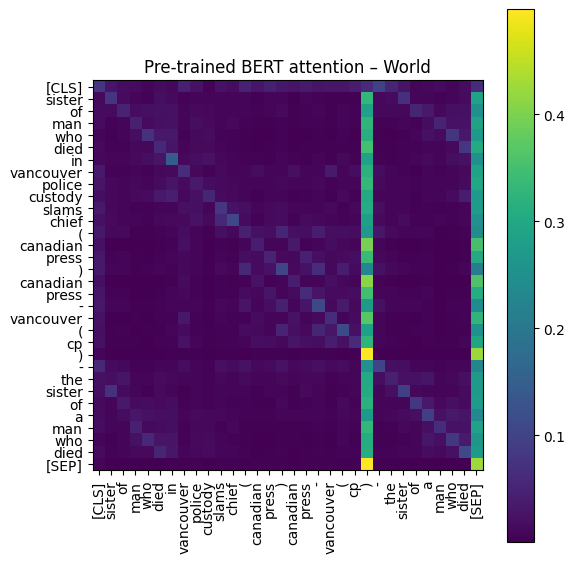

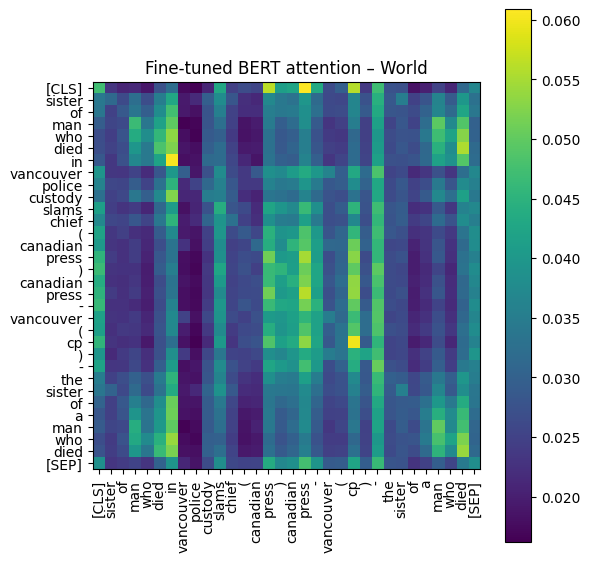


=== Sports headline ===
Giddy Phelps Touches Gold for First Time Michael Phelps won the gold medal in the 400 individual medley and set a world record in a time of 4 minutes 8. 



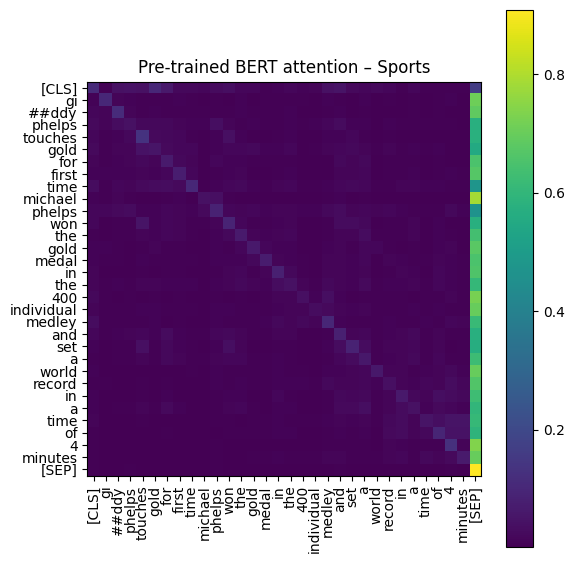

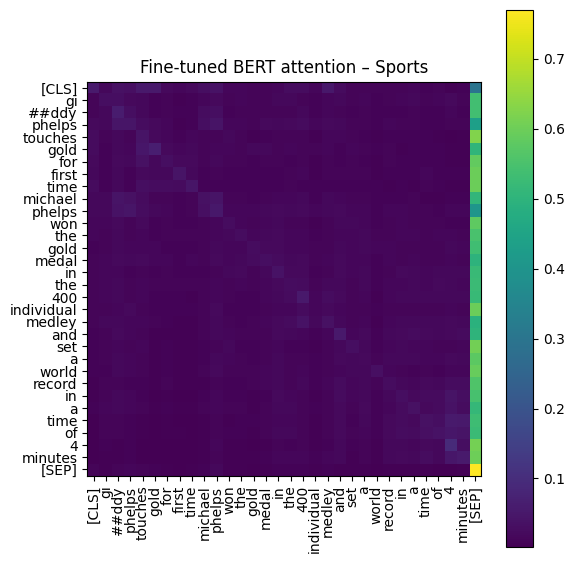


=== Business headline ===
Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul. 



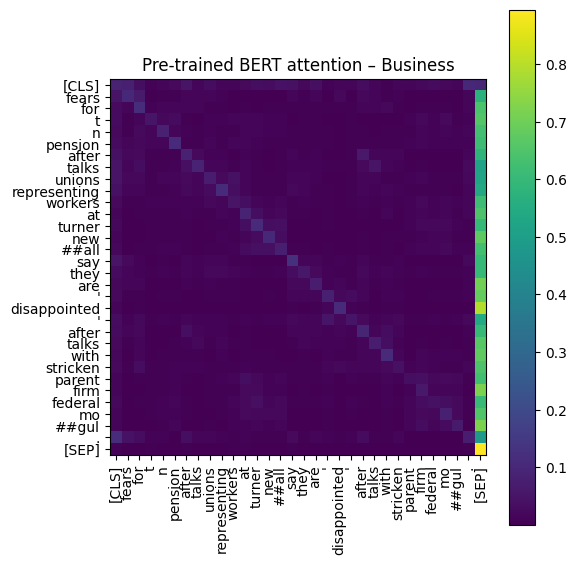

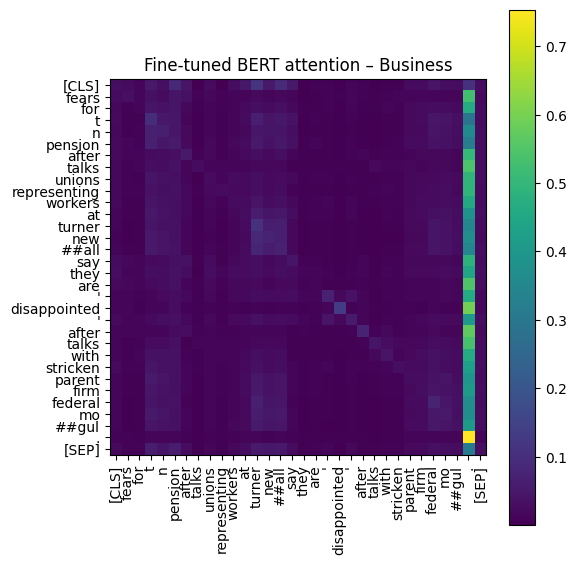


=== Sci/Tech headline ===
The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE. 



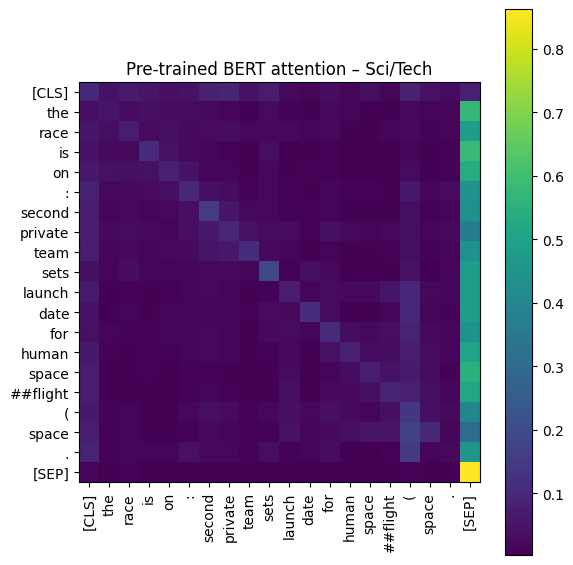

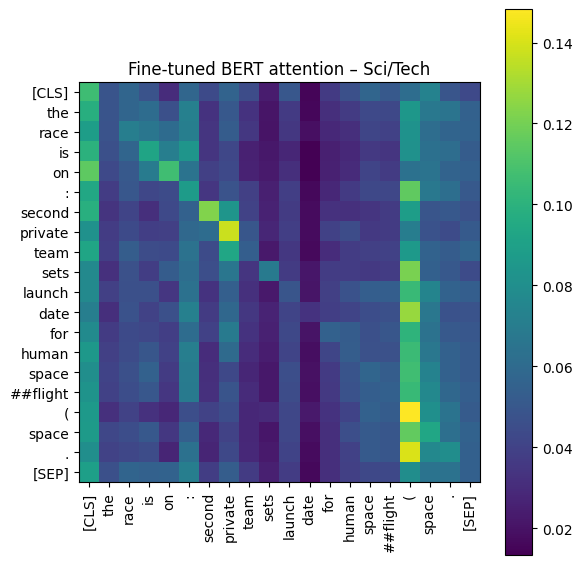

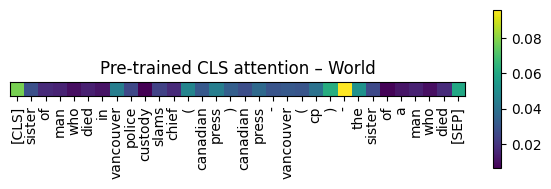

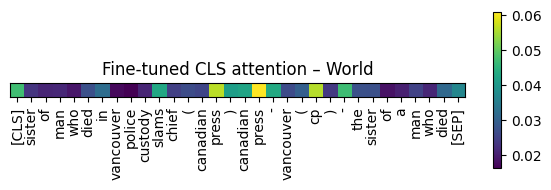

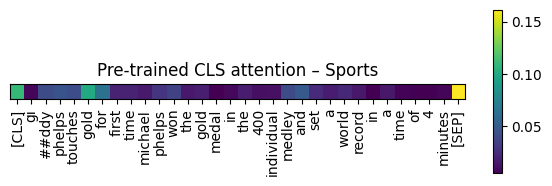

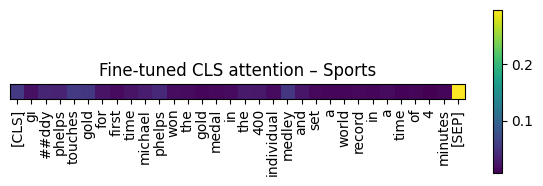

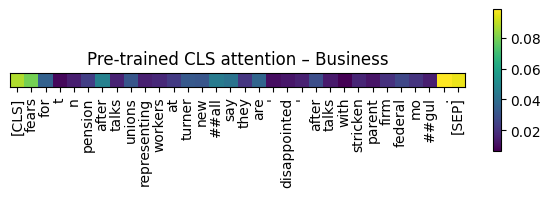

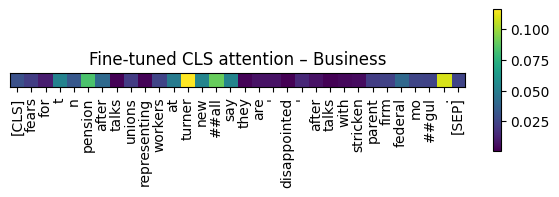

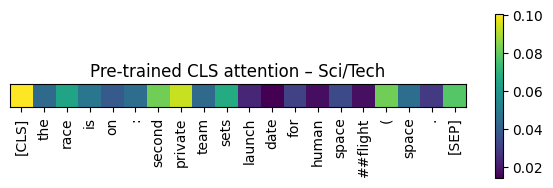

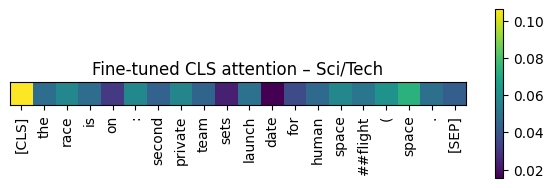

In [21]:
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

base_model = BertModel.from_pretrained(
    "bert-base-uncased",
    output_attentions=True
).to(device)
base_model.eval()

finetuned_model = BertModel.from_pretrained(
    "./bert_agnews_finetuned",
    output_attentions=True
).to(device)
finetuned_model.eval()

dataset = load_dataset("ag_news")
label_names = ["World", "Sports", "Business", "Sci/Tech"]

def headline(text):
    # crude "first sentence" heuristic
    for sep in [".", "?", "!"]:
        if sep in text:
            return text.split(sep)[0] + sep
    return text

def first_headline_for_label(label_id):
    for ex in dataset["test"]:
        if ex["label"] == label_id:
            return headline(ex["text"])
    return None

example_sentences = [
    (label_names[i], first_headline_for_label(i))
    for i in range(4)
]

def get_last_layer_attention(model, text, max_len=32):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_len
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    last_att = outputs.attentions[-1][0]      # [num_heads, seq_len, seq_len]
    att_mean = last_att.mean(dim=0).cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    return att_mean, tokens

def plot_attention(att, tokens, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(att)
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(tokens)
    ax.set_title(title)
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()

def get_cls_attention(model, text, max_len=32):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_len
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    last_att = outputs.attentions[-1][0]
    att_mean = last_att.mean(dim=0).cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    return att_mean[0], tokens  # CLS row

def plot_cls_attention(att_vec, tokens, title):
    fig, ax = plt.subplots(figsize=(6, 2))
    im = ax.imshow(att_vec[None, :])
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticks([])
    ax.set_title(title)
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()

# Full last-layer attention

for label, text in example_sentences:
    print(f"\n=== {label} headline ===")
    print(text, "\n")

    pre_att, tokens = get_last_layer_attention(base_model, text)
    fine_att, _     = get_last_layer_attention(finetuned_model, text)

    plot_attention(pre_att, tokens, f"Pre-trained BERT attention – {label}")
    plot_attention(fine_att, tokens, f"Fine-tuned BERT attention – {label}")

# CLS attention

for label, text in example_sentences:
    pre_cls, tokens = get_cls_attention(base_model, text)
    fine_cls, _     = get_cls_attention(finetuned_model, text)

    plot_cls_attention(pre_cls, tokens, f"Pre-trained CLS attention – {label}")
    plot_cls_attention(fine_cls, tokens, f"Fine-tuned CLS attention – {label}")
